Uses a local copy f the digital-land datasette to generate a csv file with the info needed to retire the dfuplicated endpoints.

Download the digital land SQLite3 file from https://datasette.planning.data.gov.uk/digital-land. You can then set the path to it per the next section. note how to do it from WSL2 to your windows host :-) 

In [11]:
dbfile =r'/mnt/c/Users/MarkSmith/Downloads/digital-land.sqlite3'
csvfile = r'/mnt/c/Users/MarkSmith/Downloads/duplicates.csv'

In [12]:
import sqlite3
import pandas as pd
import matplotlib 

# Create the connection
cnx = sqlite3.connect(dbfile)

cursor = cnx.cursor()


In [13]:
cursor.execute("drop view duplicates")

duplicates_view_sql = """
create view duplicates as 
select org.name || '_' || ds.name as dupkey,  ds.name as dataset,  count( res.resource) as count 
from resource res
inner join resource_organisation ro on ro.resource = res.resource
inner join organisation org on org.organisation = ro.organisation
inner join resource_dataset rd on rd.resource = res.resource
inner join dataset ds on ds.dataset = rd.dataset
where res.end_date = ''
group by 1
having count > 1
"""

cursor.execute(duplicates_view_sql)

df = pd.read_sql_query("SELECT * FROM duplicates", cnx)

df

,dupkey,dataset,count
0,Allerdale Borough Council_Brownfield land,Brownfield land,2
1,Amber Valley Borough Council_Brownfield land,Brownfield land,4
2,Arun District Council_Brownfield land,Brownfield land,3
3,Ashfield District Council_Brownfield land,Brownfield land,2
4,Barrow-in-Furness Borough Council_Brownfield land,Brownfield land,2
...,...,...,...
144,Wigan Metropolitan Borough Council_Brownfield ...,Brownfield land,3
145,Winchester City Council_Brownfield land,Brownfield land,5
146,Woking Borough Council_Brownfield land,Brownfield land,2
147,Wokingham Borough Council_Brownfield land,Brownfield land,2


dataset
Article 4 direction area             14
Brownfield land                     273
Conservation area                     6
Design code area                      2
Developer agreement                  20
Developer agreement contribution     18
Developer agreement transaction      18
Green belt                            7
Infrastructure funding statement     22
Listed building outline               3
Tree preservation order               6
Tree preservation zone                7
Name: count, dtype: int64


<Axes: ylabel='count'>

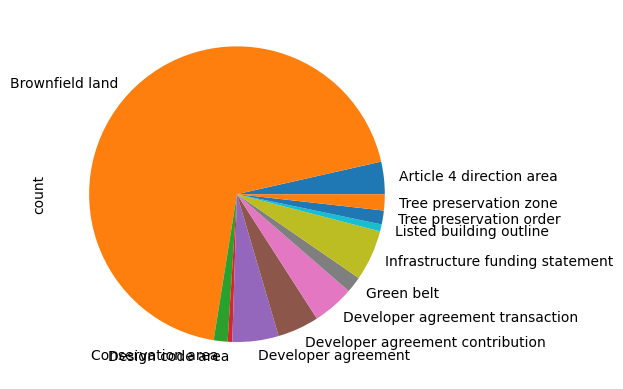

In [14]:
bydataset = df.groupby('dataset')['count'].sum()
print(bydataset)
bydataset.plot.pie()

Now we can build out the endpoints that are candidates for retiring.

In [15]:
sql = """
select org.name || '_' || ds.name as thiskey, org.name as organization, ds.name as dataset, 
res.start_date, res.resource, ep.endpoint, ep.endpoint_url, ep.start_date, ep.end_date

from resource res
inner join resource_organisation ro on ro.resource = res.resource
inner join organisation org on org.organisation = ro.organisation
inner join resource_dataset rd on rd.resource = res.resource
inner join dataset ds on ds.dataset = rd.dataset
inner join resource_endpoint re on re.resource = res.resource
inner join endpoint ep on ep.endpoint = re.endpoint

where res.end_date = ''
and thiskey in (select dupkey from duplicates)
order by 2,3,4
"""

df = pd.read_sql_query(sql, cnx)

df.to_csv(csvfile)

df

,thiskey,organization,dataset,start_date,resource,endpoint,endpoint_url,start_date,end_date
0,Allerdale Borough Council_Brownfield land,Allerdale Borough Council,Brownfield land,2018-05-22,3b694528538878d378fd6892a649fa634f0013ef299331...,5a0fcb2fdbe9d6f407b554642ab661a897a02c7a9e068a...,https://www-cloudfront.allerdale.gov.uk/media/...,2017-12-20,2019-11-25
1,Allerdale Borough Council_Brownfield land,Allerdale Borough Council,Brownfield land,2018-05-22,3b694528538878d378fd6892a649fa634f0013ef299331...,9c2e8adfd12b4f474e7d511580029d1e69d1e08a17e0cb...,https://df4iy9syor5px.cloudfront.net/media/fil...,2017-12-20,
2,Allerdale Borough Council_Brownfield land,Allerdale Borough Council,Brownfield land,2023-07-08,d9d75707f0d600188137b494978bcd1b6fb6003f61495c...,734a30c885515b42eaa004258aede2f048e49ad136d28b...,https://www-cloudfront.allerdale.gov.uk/media/...,2023-07-06,
3,Amber Valley Borough Council_Brownfield land,Amber Valley Borough Council,Brownfield land,2018-05-22,93264a2648d3dbbf4a154681831e006fb7ee7bbec0a46a...,c0fcdc64525d3be69736427cd397bf5a3c2d68104e8a90...,http://info.ambervalley.gov.uk/shareddatasets/...,2017-12-22,
4,Amber Valley Borough Council_Brownfield land,Amber Valley Borough Council,Brownfield land,2019-11-23,27710b83c46fb36c73ae7eb3d9011e7cd2488c535e04c7...,239f7a38efe51fb6271d40bd76dd7413fecb458a5c4d1e...,http://info.ambervalley.gov.uk/shareddatasets/...,,
...,...,...,...,...,...,...,...,...,...
448,Woking Borough Council_Brownfield land,Woking Borough Council,Brownfield land,2022-12-24,0926985544238c3b43555433cadeb840b5aa422503870e...,b23d3b7b05aac7b35722507f35cf8c1292d67e7897b878...,https://www.woking2027.info/ldfregisters/brown...,,
449,Wokingham Borough Council_Brownfield land,Wokingham Borough Council,Brownfield land,2020-12-31,ca61cc5fc6301e02b6fe5794c0261f0c41bdd985d5b5bf...,2216d0e013bb92ecfef70a3cf237e1c6bdf2dbb93e4c97...,https://www.wokingham.gov.uk/_resources/assets...,,
450,Wokingham Borough Council_Brownfield land,Wokingham Borough Council,Brownfield land,2022-12-24,0926985544238c3b43555433cadeb840b5aa422503870e...,b23d3b7b05aac7b35722507f35cf8c1292d67e7897b878...,https://www.woking2027.info/ldfregisters/brown...,,
451,Yorkshire Dales National Park Authority_Brownf...,Yorkshire Dales National Park Authority,Brownfield land,2019-12-01,a11c34820ff047d46acc20692d22a01bbaa4a760383125...,97a072ab424e2b395285ca1dd577ee58d2e7b7d192e69d...,https://www.yorkshiredales.org.uk/wp-content/u...,,
